## 1. Importing necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
from IPython.display import display
from collections import defaultdict

import os
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

import spacy  # For preprocessing

import logging

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/News_Category_Dataset_v3.json.zip

Archive:  /content/drive/MyDrive/News_Category_Dataset_v3.json.zip
replace News_Category_Dataset_v3.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: News_Category_Dataset_v3.json  


In [ ]:
!gzip -d /content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz

gzip: /content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz: No such file or directory


## 2. Loading Data

In [ ]:
news_articles = pd.read_json("/content/News_Category_Dataset_v3.json", lines = True)
df = news_articles.copy()

In [ ]:
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [ ]:
news_articles.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


## 3. Data Preprocessing

In [ ]:
news_articles = news_articles[news_articles['date'] >= pd.Timestamp(2018,1,1)]

In [ ]:
news_articles.shape

(17257, 6)

In [ ]:
news_articles = news_articles[news_articles['headline'].apply(lambda x: len(x.split())>5)]
print("Total number of articles after removal of headlines with short title:", news_articles.shape[0])

Total number of articles after removal of headlines with short title: 17183


In [ ]:
news_articles.sort_values('headline',inplace=True, ascending=False)
duplicated_articles_series = news_articles.duplicated('headline', keep = False)
news_articles = news_articles[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removing duplicates: 17113


In [ ]:
news_articles.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

## 4. Basic Data Exploration

### 4.a Basic statistics - Number of articles,authors,categories

In [ ]:
print("Total number of articles : ", news_articles.shape[0])
print("Total number of authors : ", news_articles["authors"].nunique())
print("Total number of unqiue categories : ", news_articles["category"].nunique())

Total number of articles :  17113
Total number of authors :  2256
Total number of unqiue categories :  36


### 4.b Distribution of articles category-wise

In [ ]:
fig = go.Figure([go.Bar(x=news_articles["category"].value_counts().index, y=news_articles["category"].value_counts().values)])
fig['layout'].update(title={"text" : 'Distribution of articles category-wise','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Category name",yaxis_title="Number of articles")
fig.update_layout(width=800,height=700)
fig

In [ ]:
news_articles_per_month = news_articles.resample('m',on = 'date')['headline'].count()
news_articles_per_month

date
2018-01-31    2065
2018-02-28    1694
2018-03-31    1778
2018-04-30    1580
2018-05-31    1391
2018-06-30     136
2018-07-31     155
2018-08-31     123
2018-09-30     156
2018-10-31     182
2018-11-30     175
2018-12-31     180
2019-01-31     181
2019-02-28     168
2019-03-31     179
2019-04-30     147
2019-05-31     152
2019-06-30     153
2019-07-31     157
2019-08-31     161
2019-09-30     163
2019-10-31     183
2019-11-30     174
2019-12-31     181
2020-01-31     154
2020-02-29     132
2020-03-31     161
2020-04-30     170
2020-05-31     179
2020-06-30     176
2020-07-31     185
2020-08-31     180
2020-09-30     172
2020-10-31     175
2020-11-30     178
2020-12-31     181
2021-01-31     183
2021-02-28     140
2021-03-31     164
2021-04-30     176
2021-05-31     184
2021-06-30     176
2021-07-31     180
2021-08-31     175
2021-09-30     168
2021-10-31     174
2021-11-30     170
2021-12-31     170
2022-01-31     149
2022-02-28     152
2022-03-31     174
2022-04-30     162
2022-05

In [ ]:
fig = go.Figure([go.Bar(x=news_articles_per_month.index.strftime("%b"), y=news_articles_per_month)])
fig['layout'].update(title={"text" : 'Distribution of articles month-wise','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Month",yaxis_title="Number of articles")
fig.update_layout(width=500,height=500)
fig

### 4.d PDF for the length of headlines

In [ ]:
fig = ff.create_distplot([news_articles['headline'].str.len()], ["ht"],show_hist=False,show_rug=False)
fig['layout'].update(title={'text':'PDF','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of a headline",yaxis_title="probability")
fig.update_layout(showlegend = False,width=500,height=500)
fig

In [ ]:
news_articles.index = range(news_articles.shape[0])

In [ ]:
# Adding a new column containing both day of the week and month, it will be required later while recommending based on day of the week and month
news_articles["day and month"] = news_articles["date"].dt.strftime("%a") + "_" + news_articles["date"].dt.strftime("%b")

In [ ]:
news_articles_temp = news_articles.copy()
df=news_articles.copy()

## 5. Text Preprocessing

### 5.a Stopwords removal

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for word in news_articles_temp["headline"][i].split():
        word = ("".join(e for e in word if e.isalnum()))
        word = word.lower()
        if not word in stop_words:
          string += word + " "
    if(i%1000==0):
      print(i)           # To track number of records processed
    news_articles_temp.at[i,"headline"] = string.strip()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


### 5.b Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for w in word_tokenize(news_articles_temp["headline"][i]):
        string += lemmatizer.lemmatize(w,pos = "v") + " "
    news_articles_temp.at[i, "headline"] = string.strip()
    if(i%1000==0):
        print(i)           # To track number of records processed

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


## 6. Headline based similarity on new articles

### 6.a Using Bag of Words method

In [ ]:
headline_vectorizer = CountVectorizer()
headline_features   = headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [ ]:
headline_features.get_shape()

(17113, 16481)

In [ ]:
def bag_of_words_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features,headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,1]
    return df.iloc[1:,]

bag_of_words_based_model(133, 11) # Change the row index for any other queried article

============================== Queried article details ==============================
headline :  Yovanovitch Responds To Trump Twitter Attacks In Real Time In Dramatic Impeachment Testimony

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2019-11-15,Twitter Users Smack Down Trump's Attack On Mar...,3.000000
2,2022-05-17,Donald Trump Is Back On Twitter,3.162278
3,2019-09-26,Here Are The Democratic Impeachment Holdouts,3.316625
4,2018-01-20,How The LA Times Union Won,3.316625
5,2019-11-16,Pelosi On Trump's Yovanovitch Attack: He Knows...,3.316625
6,2019-10-22,Trump Likens Impeachment Inquiry To 'A Lynchin...,3.316625
7,2018-02-02,The Real Purpose Of The Nunes Memo,3.464102
8,2019-01-29,Who Congress Follows On Twitter — Exposed!,3.464102
9,2022-02-03,How To Salvage Your Vacation If It Rains Most ...,3.464102
10,2020-03-18,Solidarity In A Time Of Social Distancing,3.464102


### 6.b Using TF-IDF method

In [ ]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [ ]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features,tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)

    #return df.iloc[1:,1]
    return df.iloc[1:,]
tfidf_based_model(133, 11)

============================== Queried article details ==============================
headline :  Yovanovitch Responds To Trump Twitter Attacks In Real Time In Dramatic Impeachment Testimony

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2019-11-15,Twitter Users Smack Down Trump's Attack On Mar...,1.116687
2,2019-11-16,Pelosi On Trump's Yovanovitch Attack: He Knows...,1.138892
3,2018-09-27,"Conservatives, Right-Wing Media Respond To Chr...",1.241658
4,2018-01-03,"Trump Jokes About 'Fake' Media Awards, But Twi...",1.253860
5,2021-07-21,Dramatic Videos Show Deadly Flooding In China,1.265020
6,2019-10-22,Trump Likens Impeachment Inquiry To 'A Lynchin...,1.268936
7,2022-05-17,Donald Trump Is Back On Twitter,1.278591
8,2018-02-14,Donald Trump Jr. Attacks Olympian Adam Rippon ...,1.282941
9,2019-10-15,Trump Appears To Call For His Own Impeachment ...,1.286440
10,2021-01-25,Lawmakers Face Threat Of Second Capitol Attack...,1.290482


### 6.c Using Word2Vec embedding

In [ ]:
import gensim

# Load Google's pre-trained Word2Vec model.
model=gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/GoogleNews-vectors-negative300.bin", binary=True)

importing from bin file

In [ ]:
import gensim

# Load Google's pre-trained Word2Vec model.
loaded_model=gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
loaded_model['porter']

array([-0.0390625 ,  0.05883789, -0.25195312,  0.25390625,  0.24316406,
        0.15234375,  0.04248047, -0.08349609,  0.02929688,  0.05419922,
       -0.0168457 , -0.25      ,  0.28515625, -0.13085938,  0.046875  ,
        0.00157166, -0.09570312, -0.05541992,  0.3671875 , -0.25390625,
       -0.31054688, -0.0559082 ,  0.20507812,  0.36914062,  0.08984375,
        0.03491211, -0.17382812,  0.13671875,  0.21777344, -0.20410156,
        0.140625  , -0.19335938,  0.08349609, -0.10644531, -0.12988281,
       -0.06225586,  0.08007812,  0.18359375, -0.16699219, -0.03564453,
       -0.23828125, -0.23242188,  0.26367188,  0.07958984,  0.17382812,
       -0.234375  , -0.49023438, -0.07568359, -0.14550781, -0.03881836,
        0.04443359,  0.04199219,  0.10595703, -0.20117188,  0.0145874 ,
       -0.4609375 ,  0.13476562,  0.14550781, -0.25390625, -0.3359375 ,
       -0.078125  ,  0.10791016, -0.25195312, -0.02783203,  0.29492188,
        0.140625  , -0.11572266, -0.38085938,  0.04760742,  0.18

In [ ]:
print(list(loaded_model.index_to_key)[0:100])

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'It', 'all', 'also', 'two', 'after', 'first', 'He', 'do', 'time', 'than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'In', 'our', 'there', 'A', 'she', 'could', 'just', 'years', 'some', 'U.S.', 'three', 'million', 'them', 'what', 'But', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', '#.#', 'before']


In [ ]:
vocabulary = list(loaded_model.index_to_key)
w2v_headline = []
for i in news_articles_temp['headline']:
    w2Vec_word = np.zeros(300, dtype="float32")
    for word in i.split():
        if word in vocabulary:
            w2Vec_word = np.add(w2Vec_word, loaded_model[word])
    w2Vec_word = np.divide(w2Vec_word, len(i.split()))
    w2v_headline.append(w2Vec_word)
w2v_headline = np.array(w2v_headline)

In [ ]:
def avg_w2v_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,1]
    return df.iloc[1:,]

avg_w2v_based_model(133, 11)

============================== Queried article details ==============================
headline :  Yovanovitch Responds To Trump Twitter Attacks In Real Time In Dramatic Impeachment Testimony

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2019-10-09,Late Night Hosts Find The Funny In Latest Dona...,0.922826
2,2018-03-18,"Trump Attacks McCabe, Comey And Mueller Probe ...",0.933982
3,2018-01-10,Seth Meyers Has The Best Response To Trump Rep...,0.937962
4,2019-10-24,Colbert Hits Trump's Self-Congratulatory Speec...,0.942128
5,2019-10-30,Colbert Nails The GOP's Big Problem With Tryin...,0.948317
6,2018-09-28,Trump On Kavanaugh: ‘Con Job’ To ‘Senate Must ...,0.950672
7,2018-10-17,Ben Sasse Reacts To Trump's 'Horseface' Commen...,0.951635
8,2021-10-15,Kayleigh McEnany Attacks Jen Psaki With ‘Least...,0.954004
9,2020-09-19,Ex-Pence Aide: Trump Derailed COVID-19 Meeting...,0.957979
10,2018-05-16,Pauley Perrette Responds To CBS Statement Abou...,0.958562


### 6.d Weighted similarity based on headline and category

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
category_onehot_encoded = OneHotEncoder().fit_transform(np.array(news_articles_temp["category"]).reshape(-1,1))

In [ ]:
def avg_w2v_with_category(row_index, num_similar_items, w1,w2): #headline_preference = True, category_preference = False):
    w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist)/float(w1 + w2)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'Word2Vec based Euclidean similarity': w2v_dist[indices].ravel(),
                 'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values})

    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,5]]
    return df.iloc[1:, ]

avg_w2v_with_category(528,10,0.1,0.8)

============================== Queried article details ==============================
headline :  White House Staff Secretary Rob Porter Resigns Over Abuse Allegations
Categoty :  POLITICS

 ========================= Recommended articles :  =======================


,publish_date,headline,Weighted Euclidean similarity with the queried article,Word2Vec based Euclidean similarity,Category based Euclidean similarity,Categoty
1,2018-02-09,White House Counsel Knew About Rob Porter Accu...,0.976359,0.787234,1.0,POLITICS
2,2018-02-10,Another White House Staffer Resigns Over Domes...,0.978129,0.803165,1.0,POLITICS
3,2018-02-13,FBI Chief Disputes White House Claims On When ...,0.982633,0.843700,1.0,POLITICS
4,2018-04-27,White House Knew About Rob Porter Allegations ...,0.986051,0.874457,1.0,POLITICS
5,2018-02-16,GOP Lawmaker On Rob Porter Abuse Allegations: ...,0.993232,0.939084,1.0,POLITICS
6,2018-02-11,"White House Officials Can't Say Who Knew What,...",0.999987,0.999882,1.0,POLITICS
7,2018-03-09,White House Refuses House Investigation Reques...,1.000364,1.003274,1.0,POLITICS
8,2018-02-09,Rob Porter's Ex-Wife Said He Asked Her To 'Dow...,1.000665,1.005986,1.0,POLITICS
9,2022-06-10,Jared Kushner Dismissed White House Counsel's ...,1.003790,1.034108,1.0,POLITICS


### 6.e Weighted similarity based on headline, category and author

In [ ]:
authors_onehot_encoded = OneHotEncoder().fit_transform(np.array(news_articles_temp["authors"]).reshape(-1,1))

In [ ]:
def avg_w2v_with_category_and_authors(row_index, num_similar_items, w1,w2,w3): #headline_preference = True, category_preference = False):
    w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist)/float(w1 + w2 + w3)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline':news_articles['headline'][indices].values,
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'Word2Vec based Euclidean similarity': w2v_dist[indices].ravel(),
                'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Authors based Euclidean similarity': authors_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,6,7]]
    return df.iloc[1:, ]


avg_w2v_with_category_and_authors(528,10,0.1,0.1,1)

============================== Queried article details ==============================
headline :  White House Staff Secretary Rob Porter Resigns Over Abuse Allegations
Categoty :  POLITICS
Authors :  Sebastian Murdock

 ========================= Recommended articles :  =======================


,publish_date,headline,Weighted Euclidean similarity with the queried article,Word2Vec based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Categoty,Authors
1,2018-02-07,John Kelly Calls Aide Facing Abuse Allegations...,1.004848,1.058172,1.0,1.0,POLITICS,Sebastian Murdock
2,2018-02-08,Fox News Predictably Quiet On Former White Hou...,1.008547,1.102569,1.0,1.0,POLITICS,Sebastian Murdock
3,2018-03-17,Mike Huckabee Celebrates Firing Of Former FBI ...,1.014724,1.176684,1.0,1.0,POLITICS,Sebastian Murdock
4,2018-02-02,New York State Senate's New Sex Harassment Pol...,1.021709,1.260511,1.0,1.0,POLITICS,Sebastian Murdock
5,2018-01-26,Hillary Clinton Reportedly Kept An Adviser Acc...,1.022157,1.265889,1.0,1.0,POLITICS,Sebastian Murdock
6,2018-01-09,Ruth Bader Ginsburg Has Law Clerks Lined Up Un...,1.022268,1.267220,1.0,1.0,POLITICS,Sebastian Murdock
7,2018-02-10,President Who Loves Making False Accusations S...,1.022361,1.268332,1.0,1.0,POLITICS,Sebastian Murdock
8,2021-01-28,Man Arrested Near Capitol With Gun Had 'Stop T...,1.024225,1.290694,1.0,1.0,POLITICS,Sebastian Murdock
9,2018-09-14,Some Republicans Stick By Brett Kavanaugh In F...,1.024253,1.291035,1.0,1.0,POLITICS,Sebastian Murdock


### 6.f Weighted similarity based on headline, category, author and publishing day

In [ ]:
publishingday_onehot_encoded = OneHotEncoder().fit_transform(np.array(news_articles_temp["day and month"]).reshape(-1,1))

In [ ]:
def avg_w2v_with_category_authors_and_publshing_day(row_index, num_similar_items, w1,w2,w3,w4): #headline_preference = True, category_preference = False):
    couple_dist = pairwise_distances(headline_features,headline_features[row_index])
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
    publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * couple_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist)/float(w1 + w2 + w3 + w4)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline_text':news_articles['headline'][indices].values,
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'BoW based Euclidean similarity': couple_dist[indices].ravel(),
                'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Authors based Euclidean similarity': authors_dist[indices].ravel(),
                'Publishing day based Euclidean similarity': publishingday_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values,
                'Day and month': news_articles['day and month'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print('Day and month : ', news_articles['day and month'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,7,8,9]]
    return df.iloc[1:, ]


avg_w2v_with_category_authors_and_publshing_day(528,10,0.1,0.1,0.1,1)

============================== Queried article details ==============================
headline :  White House Staff Secretary Rob Porter Resigns Over Abuse Allegations
Categoty :  POLITICS
Authors :  Sebastian Murdock
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,Weighted Euclidean similarity with the queried article,BoW based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
1,2018-02-07,John Kelly Calls Aide Facing Abuse Allegations...,1.220999,3.872983,1.0,1.000000,1.0,POLITICS,Sebastian Murdock,Wed_Feb
2,2018-02-14,Colorado Teacher Charged After Allegedly Forci...,1.240239,4.123106,1.0,1.000000,1.0,POLITICS,Sebastian Murdock,Wed_Feb
3,2018-02-28,Hope Hicks Is Leaving The White House,1.275115,3.162278,1.0,2.414214,1.0,POLITICS,Lydia O'Connor,Wed_Feb
4,2018-02-14,Washington Insider: White House Story On Porte...,1.286988,3.316625,1.0,2.414214,1.0,POLITICS,"Hunter Walker, Yahoo News",Wed_Feb
5,2018-02-14,House Oversight Panel Investigating Alleged Ab...,1.286988,3.316625,1.0,2.414214,1.0,POLITICS,Sara Boboltz,Wed_Feb
6,2018-02-14,Can There Be Equity In The Bike Lane?,1.298332,3.464102,1.0,2.414214,1.0,POLITICS,"Stateline, Editorial Partner",Wed_Feb
7,2019-02-27,White House Bars Some Reporters From Trump-Kim...,1.298332,3.464102,1.0,2.414214,1.0,POLITICS,Hayley Miller,Wed_Feb
8,2018-02-07,Everything You Should Know About The Stock Market,1.309213,3.605551,1.0,2.414214,1.0,POLITICS,Zach Carter,Wed_Feb
9,2018-02-28,Democrats Flip 2 More GOP-Held State House Seats,1.309213,3.605551,1.0,2.414214,1.0,POLITICS,Rebecca Shapiro,Wed_Feb


In [ ]:
def avg_w2v_with_category_authors_and_publshing_day(row_index, num_similar_items, w1,w2,w3,w4): #headline_preference = True, category_preference = False):
    couple_dist = pairwise_distances(tfidf_headline_features,tfidf_headline_features[row_index])
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
    publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * couple_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist)/float(w1 + w2 + w3 + w4)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline_text':news_articles['headline'][indices].values,
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'tfidf based Euclidean similarity': couple_dist[indices].ravel(),
                'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Authors based Euclidean similarity': authors_dist[indices].ravel(),
                'Publishing day based Euclidean similarity': publishingday_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values,
                'Day and month': news_articles['day and month'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print('Day and month : ', news_articles['day and month'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,7,8,9]]
    return df.iloc[1:, ]


avg_w2v_with_category_authors_and_publshing_day(528,10,0.1,0.1,0.1,1)

============================== Queried article details ==============================
headline :  White House Staff Secretary Rob Porter Resigns Over Abuse Allegations
Categoty :  POLITICS
Authors :  Sebastian Murdock
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,Weighted Euclidean similarity with the queried article,tfidf based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
1,2018-02-07,John Kelly Calls Aide Facing Abuse Allegations...,1.021127,1.274645,1.0,1.000000,1.0,POLITICS,Sebastian Murdock,Wed_Feb
2,2018-02-14,Colorado Teacher Charged After Allegedly Forci...,1.031863,1.414214,1.0,1.000000,1.0,POLITICS,Sebastian Murdock,Wed_Feb
3,2018-02-14,House Oversight Panel Investigating Alleged Ab...,1.120645,1.154165,1.0,2.414214,1.0,POLITICS,Sara Boboltz,Wed_Feb
4,2018-02-14,Washington Insider: White House Story On Porte...,1.124174,1.200043,1.0,2.414214,1.0,POLITICS,"Hunter Walker, Yahoo News",Wed_Feb
5,2018-02-28,Hicks Declines To Answer House Committee's Que...,1.130786,1.286009,1.0,2.414214,1.0,POLITICS,"Patricia Zengerle, Reuters",Wed_Feb
6,2018-02-28,Hope Hicks Is Leaving The White House,1.130965,1.288335,1.0,2.414214,1.0,POLITICS,Lydia O'Connor,Wed_Feb
7,2018-02-14,Trump Finally Speaks Out Against Domestic Viol...,1.131453,1.294673,1.0,2.414214,1.0,POLITICS,Lydia O'Connor,Wed_Feb
8,2019-02-27,White House Bars Some Reporters From Trump-Kim...,1.133518,1.321518,1.0,2.414214,1.0,POLITICS,Hayley Miller,Wed_Feb
9,2018-02-07,Senators To Investigate USA Gymnastics And U.S...,1.135832,1.351605,1.0,2.414214,1.0,POLITICS,Rebecca Shapiro,Wed_Feb


In [ ]:
def avg_w2v_with_category_authors_and_publshing_day(row_index, num_similar_items, w1,w2,w3,w4): #headline_preference = True, category_preference = False):
    w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
    publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist)/float(w1 + w2 + w3 + w4)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline_text':news_articles['headline'][indices].values,
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'Word2Vec based Euclidean similarity': w2v_dist[indices].ravel(),
                'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Authors based Euclidean similarity': authors_dist[indices].ravel(),
                'Publishing day based Euclidean similarity': publishingday_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values,
                'Day and month': news_articles['day and month'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print('Day and month : ', news_articles['day and month'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,7,8,9]]
    return df.iloc[1:, ]


avg_w2v_with_category_authors_and_publshing_day(528,10,0.1,0.1,0.1,1)

============================== Queried article details ==============================
headline :  White House Staff Secretary Rob Porter Resigns Over Abuse Allegations
Categoty :  POLITICS
Authors :  Sebastian Murdock
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,Weighted Euclidean similarity with the queried article,Word2Vec based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
1,2018-02-07,John Kelly Calls Aide Facing Abuse Allegations...,1.004475,1.058172,1.0,1.000000,1.0,POLITICS,Sebastian Murdock,Wed_Feb
2,2018-02-14,Colorado Teacher Charged After Allegedly Forci...,1.025353,1.329590,1.0,1.000000,1.0,POLITICS,Sebastian Murdock,Wed_Feb
3,2018-02-14,House Oversight Panel Investigating Alleged Ab...,1.113059,1.055557,1.0,2.414214,1.0,POLITICS,Sara Boboltz,Wed_Feb
4,2018-02-14,Trump Finally Speaks Out Against Domestic Viol...,1.125266,1.214239,1.0,2.414214,1.0,POLITICS,Lydia O'Connor,Wed_Feb
5,2018-02-14,Washington Insider: White House Story On Porte...,1.126921,1.235754,1.0,2.414214,1.0,POLITICS,"Hunter Walker, Yahoo News",Wed_Feb
6,2022-02-23,Kentucky Elects First Openly LGBTQ State House...,1.128610,1.257718,1.0,2.414214,1.0,POLITICS,Travis Waldron,Wed_Feb
7,2018-02-28,Trump's New Campaign Head Linked To Company Wi...,1.130792,1.286086,1.0,2.414214,1.0,POLITICS,Carla Herreria,Wed_Feb
8,2018-02-07,RNC Still Says It Won't Return Alleged Sexual ...,1.131350,1.293338,1.0,2.414214,1.0,POLITICS,Marina Fang,Wed_Feb
9,2018-02-21,School Shooting's Survivors Cry As Florida Hou...,1.133070,1.315693,1.0,2.414214,1.0,POLITICS,Doha Madani,Wed_Feb


In [ ]:
def avg_w2v_with_category_authors_and_publshing_day(row_index, num_similar_items, w1,w2,w3,w4): #headline_preference = True, category_preference = False):
    w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1),metric='cosine')
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index],metric='cosine')
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index],metric='cosine')
    publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index],metric='cosine')
    weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist)/float(w1 + w2 + w3 + w4)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline_text':news_articles['headline'][indices].values,
                'Weighted Cosine similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'Word2Vec based Cosine similarity': w2v_dist[indices].ravel(),
                'Category based Cosine similarity': category_dist[indices].ravel(),
                'Authors based Cosine similarity': authors_dist[indices].ravel(),
                'Publishing day based Cosine similarity': publishingday_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values,
                'Day and month': news_articles['day and month'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print('Day and month : ', news_articles['day and month'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,7,8,9]]
    return df.iloc[1:, ]

avg_w2v_with_category_authors_and_publshing_day(528,10,0.1,0.1,0.1,1)

============================== Queried article details ==============================
headline :  White House Staff Secretary Rob Porter Resigns Over Abuse Allegations
Categoty :  POLITICS
Authors :  Sebastian Murdock
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,Weighted Cosine similarity with the queried article,Word2Vec based Cosine similarity,Category based Cosine similarity,Authors based Cosine similarity,Publishing day based Cosine similarity,Categoty,Authors,Day and month
1,2018-02-07,John Kelly Calls Aide Facing Abuse Allegations...,0.024702,0.321130,0.0,0.0,0.0,POLITICS,Sebastian Murdock,Wed_Feb
2,2018-02-14,Colorado Teacher Charged After Allegedly Forci...,0.040269,0.523491,0.0,0.0,0.0,POLITICS,Sebastian Murdock,Wed_Feb
3,2018-02-14,House Oversight Panel Investigating Alleged Ab...,0.098184,0.276396,0.0,1.0,0.0,POLITICS,Sara Boboltz,Wed_Feb
4,2018-02-14,Trump Finally Speaks Out Against Domestic Viol...,0.109217,0.419822,0.0,1.0,0.0,POLITICS,Lydia O'Connor,Wed_Feb
5,2018-02-14,Washington Insider: White House Story On Porte...,0.112427,0.461546,0.0,1.0,0.0,POLITICS,"Hunter Walker, Yahoo News",Wed_Feb
6,2018-02-21,Prosecutors File Criminal Charges In Case Wher...,0.115642,0.503346,0.0,1.0,0.0,POLITICS,Ryan J. Reilly,Wed_Feb
7,2018-02-21,School Shooting's Survivors Cry As Florida Hou...,0.115923,0.506995,0.0,1.0,0.0,POLITICS,Doha Madani,Wed_Feb
8,2018-02-28,Trump's New Campaign Head Linked To Company Wi...,0.116656,0.516522,0.0,1.0,0.0,POLITICS,Carla Herreria,Wed_Feb
9,2018-02-21,Why Statehouse Interns Are Especially Vulnerab...,0.116711,0.517245,0.0,1.0,0.0,POLITICS,"Stateline, Editorial Partner",Wed_Feb


### 6.g Weighted similarity based on headline, category, author and publishing day , Sentiment

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sent=news_articles['headline'].apply(sid.polarity_scores)

In [ ]:
sent_arr=[]
for i in sent:
  arr=list(i.values())
  sent_arr.append(arr)
sent_arr = np.array(sent_arr)
print(sent_arr)

[[ 0.      1.      0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.506   0.494   0.     -0.7996]
 ...
 [ 0.      1.      0.      0.    ]
 [ 0.474   0.526   0.     -0.743 ]
 [ 0.198   0.802   0.     -0.5719]]


In [ ]:
def avg_bow_with_category_authors_and_publshing_day_and_sentiment(row_index, num_similar_items, w1,w2,w3,w4,w5): #headline_preference = True, category_preference = False):
    sent_dist  = np.negative(pairwise_distances(sent_arr, sent_arr[row_index].reshape(1,-1)))
    w2v_dist  = pairwise_distances(headline_features, headline_features[row_index].reshape(1,-1))
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
    publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist + w5*sent_dist)/float(w1 + w2 + w3 + w4+w5)
    _sent_dist  = np.negative(pairwise_distances(sent_arr, sent_arr[row_index].reshape(1,-1)))
    _w2v_dist  = pairwise_distances(headline_features, headline_features[row_index].reshape(1,-1),metric='cosine')
    _category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index],metric='cosine')
    _authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index],metric='cosine')
    _publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index],metric='cosine')
    _weighted_couple_dist   = (w1 * _w2v_dist +  w2 * _category_dist + w3 * _authors_dist + w4 * _publishingday_dist + w5*_sent_dist)/float(w1 + w2 + w3 + w4+w5)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline_text':news_articles['headline'][indices].values,
                'cosine': _weighted_couple_dist[indices].ravel(),
                'article_sentiment_similarity':sent_dist[indices].ravel(),
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'BoW based Euclidean similarity': w2v_dist[indices].ravel(),
                'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Authors based Euclidean similarity': authors_dist[indices].ravel(),
                'Publishing day based Euclidean similarity': publishingday_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values,
                'Day and month': news_articles['day and month'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print('Day and month : ', news_articles['day and month'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,7,8,9]]
    display(df.iloc[1:, ])
    return indices


avg_bow_with_category_authors_and_publshing_day_and_sentiment(528,10,0.1,0.1,0.1,1,0.5)


============================== Queried article details ==============================
headline :  Rewards Program Encourages SNAP Recipients To Make Healthy Choices
Categoty :  POLITICS
Authors :  Stateline, Editorial Partner
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,cosine,article_sentiment_similarity,Weighted Euclidean similarity with the queried article,BoW based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
1,2018-02-07,Democrats Win Special Election In Missouri Dis...,-0.387279,-1.794204,0.482546,4.242641,1.000000,2.414214,1.0,POLITICS,Amanda Terkel,Wed_Feb
2,2018-02-14,Stormy Daniels Says Trump Lawyer Breached Agre...,-0.392413,-1.812686,0.483871,4.358899,1.000000,2.414214,1.0,POLITICS,Antonia Blumberg,Wed_Feb
3,2018-02-14,Americans Should Get Ready To Spend Even More ...,-0.368902,-1.728047,0.494283,4.123106,1.000000,2.414214,1.0,POLITICS,Jonathan Cohn,Wed_Feb
4,2018-02-28,Hope Hicks Is Leaving The White House,-0.323385,-1.504559,0.502983,3.162278,1.000000,2.414214,1.0,POLITICS,Lydia O'Connor,Wed_Feb
5,2018-02-14,Michelle Obama Made A Valentine's Day Playlist...,-0.339124,-1.620846,0.524060,4.123106,1.000000,2.414214,1.0,POLITICS,Carly Ledbetter,Wed_Feb
6,2018-02-14,Queer Students Celebrate Valentine's Day By Sh...,-0.365329,-1.915184,0.527508,4.242641,2.414214,2.414214,1.0,QUEER VOICES,Curtis M. Wong,Wed_Feb
7,2018-02-14,Sikh Activist's Campaign A Reminder That Love ...,-0.350634,-1.862282,0.528723,4.000000,2.414214,2.414214,1.0,RELIGION,Carol Kuruvilla,Wed_Feb
8,2018-02-14,Shaun White Makes History With Gold Medal Win ...,-0.347812,-1.828553,0.531036,3.872983,2.414214,2.414214,1.0,SPORTS,Josh Butler,Wed_Feb
9,2018-02-14,6 Queer Couples Share Their Definition of Blac...,-0.335887,-1.809192,0.536414,3.872983,2.414214,2.414214,1.0,BLACK VOICES,Princess-India Alexander,Wed_Feb


[5406, 13056, 4002, 15465, 10718, 7776, 5783, 4466, 4538, 16075]

In [ ]:
def avg_tfidf_with_category_authors_and_publshing_day_and_sentiment(row_index, num_similar_items, w1,w2,w3,w4,w5): #headline_preference = True, category_preference = False):
    sent_dist  = np.negative(pairwise_distances(sent_arr, sent_arr[row_index].reshape(1,-1)))
    w2v_dist  = pairwise_distances(tfidf_headline_features, tfidf_headline_features[row_index].reshape(1,-1))
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
    publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist + w5*sent_dist)/float(w1 + w2 + w3 + w4+w5)
    _sent_dist  = np.negative(pairwise_distances(sent_arr, sent_arr[row_index].reshape(1,-1)))
    _w2v_dist  = pairwise_distances(headline_features, headline_features[row_index].reshape(1,-1),metric='cosine')
    _category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index],metric='cosine')
    _authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index],metric='cosine')
    _publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index],metric='cosine')
    _weighted_couple_dist   = (w1 * _w2v_dist +  w2 * _category_dist + w3 * _authors_dist + w4 * _publishingday_dist + w5*_sent_dist)/float(w1 + w2 + w3 + w4+w5)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline_text':news_articles['headline'][indices].values,
                'article_sentiment_similarity':sent_dist[indices].ravel(),
                       'cosine': _weighted_couple_dist[indices].ravel(),
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'tfidf based Euclidean similarity': w2v_dist[indices].ravel(),
                'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Authors based Euclidean similarity': authors_dist[indices].ravel(),
                'Publishing day based Euclidean similarity': publishingday_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values,
                'Day and month': news_articles['day and month'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print('Day and month : ', news_articles['day and month'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,7,8,9]]
    display(df.iloc[1:, ])
    return indices


avg_tfidf_with_category_authors_and_publshing_day_and_sentiment(528,10,0.1,0.1,0.1,1,0.5)


============================== Queried article details ==============================
headline :  Rewards Program Encourages SNAP Recipients To Make Healthy Choices
Categoty :  POLITICS
Authors :  Stateline, Editorial Partner
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,article_sentiment_similarity,cosine,Weighted Euclidean similarity with the queried article,tfidf based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
1,2018-02-14,Stormy Daniels Says Trump Lawyer Breached Agre...,-1.812686,-0.392413,0.320278,1.414214,1.000000,2.414214,1.0,POLITICS,Antonia Blumberg,Wed_Feb
2,2018-02-07,Democrats Win Special Election In Missouri Dis...,-1.794204,-0.387279,0.325412,1.414214,1.000000,2.414214,1.0,POLITICS,Amanda Terkel,Wed_Feb
3,2018-02-14,Americans Should Get Ready To Spend Even More ...,-1.728047,-0.368902,0.343789,1.414214,1.000000,2.414214,1.0,POLITICS,Jonathan Cohn,Wed_Feb
4,2018-02-14,Queer Students Celebrate Valentine's Day By Sh...,-1.915184,-0.365329,0.370373,1.414214,2.414214,2.414214,1.0,QUEER VOICES,Curtis M. Wong,Wed_Feb
5,2018-02-14,Michelle Obama Made A Valentine's Day Playlist...,-1.620846,-0.339124,0.373566,1.414214,1.000000,2.414214,1.0,POLITICS,Carly Ledbetter,Wed_Feb
6,2018-02-14,Freedom Caucus Chairman Warns Paul Ryan To Tre...,-1.585411,-0.329281,0.383410,1.414214,1.000000,2.414214,1.0,POLITICS,Matt Fuller,Wed_Feb
7,2018-02-07,Kevin Durant Slam-Dunking In Super Slow Motion...,-1.862758,-0.350766,0.384936,1.414214,2.414214,2.414214,1.0,SPORTS,Lee Moran,Wed_Feb
8,2018-02-14,Sikh Activist's Campaign A Reminder That Love ...,-1.862282,-0.350634,0.385068,1.414214,2.414214,2.414214,1.0,RELIGION,Carol Kuruvilla,Wed_Feb
9,2020-02-12,"Here Are Pics Of Siba, The Supremely Extra Win...",-1.847880,-0.346633,0.389069,1.414214,2.414214,2.414214,1.0,U.S. NEWS,Josephine Harvey,Wed_Feb


[5406, 4002, 13056, 15465, 5783, 7776, 11589, 8939, 4466, 10955]

In [ ]:
def avg_w2v_with_category_authors_and_publshing_day_and_sentiment(row_index, num_similar_items, w1,w2,w3,w4,w5): #headline_preference = True, category_preference = False):
    sent_dist  = np.negative(pairwise_distances(sent_arr, sent_arr[row_index].reshape(1,-1)))
    w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
    authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
    publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index]) + 1
    weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist + w5*sent_dist)/float(w1 + w2 + w3 + w4+w5)
    indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
    _sent_dist  = np.negative(pairwise_distances(sent_arr, sent_arr[row_index].reshape(1,-1)))
    _w2v_dist  = pairwise_distances(headline_features, headline_features[row_index].reshape(1,-1),metric='cosine')
    _category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index],metric='cosine')
    _authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index],metric='cosine')
    _publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index],metric='cosine')
    _weighted_couple_dist   = (w1 * _w2v_dist +  w2 * _category_dist + w3 * _authors_dist + w4 * _publishingday_dist + w5*_sent_dist)/float(w1 + w2 + w3 + w4+w5)
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
                'headline_text':news_articles['headline'][indices].values,
                'article_sentiment_similarity':sent_dist[indices].ravel(),
                       'cosine': _weighted_couple_dist[indices].ravel(),
                'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
                'Word2Vec based Euclidean similarity': w2v_dist[indices].ravel(),
                'Category based Euclidean similarity': category_dist[indices].ravel(),
                'Authors based Euclidean similarity': authors_dist[indices].ravel(),
                'Publishing day based Euclidean similarity': publishingday_dist[indices].ravel(),
                'Categoty': news_articles['category'][indices].values,
                'Authors': news_articles['authors'][indices].values,
                'Day and month': news_articles['day and month'][indices].values})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print('Categoty : ', news_articles['category'][indices[0]])
    print('Authors : ', news_articles['authors'][indices[0]])
    print('Day and month : ', news_articles['day and month'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,[1,7,8,9]]
    display(df)

    return indices


avg_w2v_with_category_authors_and_publshing_day_and_sentiment(528,10,0.1,0.1,0.1,1,0.5)


============================== Queried article details ==============================
headline :  Rewards Program Encourages SNAP Recipients To Make Healthy Choices
Categoty :  POLITICS
Authors :  Stateline, Editorial Partner
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,article_sentiment_similarity,cosine,Weighted Euclidean similarity with the queried article,Word2Vec based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
0,2018-02-28,Rewards Program Encourages SNAP Recipients To ...,-1.899150,-0.416431,0.312269,1.702380,1.000000,2.414214,1.0,POLITICS,"Stateline, Editorial Partner",Wed_Feb
1,2018-02-14,Stormy Daniels Says Trump Lawyer Breached Agre...,-1.812686,-0.392413,0.315869,1.334860,1.000000,2.414214,1.0,POLITICS,Antonia Blumberg,Wed_Feb
2,2018-02-07,Democrats Win Special Election In Missouri Dis...,-1.794204,-0.387279,0.331598,1.525568,1.000000,2.414214,1.0,POLITICS,Amanda Terkel,Wed_Feb
3,2018-02-14,Americans Should Get Ready To Spend Even More ...,-1.728047,-0.368902,0.350261,1.530715,1.000000,2.414214,1.0,POLITICS,Jonathan Cohn,Wed_Feb
4,2018-02-14,Queer Students Celebrate Valentine's Day By Sh...,-1.915184,-0.365329,0.383206,1.645198,2.414214,2.414214,1.0,QUEER VOICES,Curtis M. Wong,Wed_Feb
5,2018-02-14,Freedom Caucus Chairman Warns Paul Ryan To Tre...,-1.585411,-0.329281,0.389197,1.518383,1.000000,2.414214,1.0,POLITICS,Matt Fuller,Wed_Feb
6,2018-02-14,Sikh Activist's Campaign A Reminder That Love ...,-1.862282,-0.350634,0.391240,1.525298,2.414214,2.414214,1.0,RELIGION,Carol Kuruvilla,Wed_Feb
7,2020-02-12,"Here Are Pics Of Siba, The Supremely Extra Win...",-1.847880,-0.346633,0.394053,1.503925,2.414214,2.414214,1.0,U.S. NEWS,Josephine Harvey,Wed_Feb
8,2018-02-07,Kevin Durant Slam-Dunking In Super Slow Motion...,-1.862758,-0.350766,0.394214,1.581208,2.414214,2.414214,1.0,SPORTS,Lee Moran,Wed_Feb
9,2018-02-14,Michelle Obama Made A Valentine's Day Playlist...,-1.620846,-0.339124,0.397675,1.848159,1.000000,2.414214,1.0,POLITICS,Carly Ledbetter,Wed_Feb


[5406, 4002, 13056, 15465, 5783, 11589, 4466, 10955, 8939, 7776]

In [ ]:
category_onehot_encoded.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
vis=np.concatenate([w2v_headline,category_onehot_encoded.toarray(),authors_onehot_encoded.toarray(),publishingday_onehot_encoded.toarray(),sent_arr],axis=1)

In [ ]:
vis.shape

(17113, 2680)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
red=TSNE().fit_transform(vis)
red.shape

(17113, 2)

In [ ]:
import tensorflow as tf

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

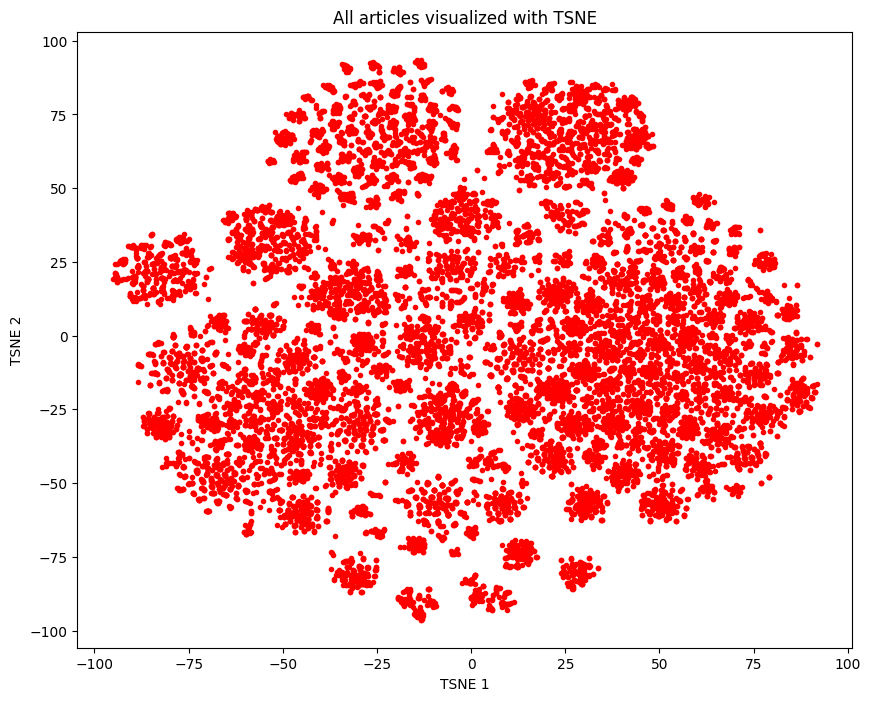

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(red[:, 0], red[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('All articles visualized with TSNE');

============================== Queried article details ==============================
headline :  Rewards Program Encourages SNAP Recipients To Make Healthy Choices
Categoty :  POLITICS
Authors :  Stateline, Editorial Partner
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,article_sentiment_similarity,cosine,Weighted Euclidean similarity with the queried article,Word2Vec based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
0,2018-02-28,Rewards Program Encourages SNAP Recipients To ...,-1.899150,-0.416431,0.312269,1.702380,1.000000,2.414214,1.0,POLITICS,"Stateline, Editorial Partner",Wed_Feb
1,2018-02-14,Stormy Daniels Says Trump Lawyer Breached Agre...,-1.812686,-0.392413,0.315869,1.334860,1.000000,2.414214,1.0,POLITICS,Antonia Blumberg,Wed_Feb
2,2018-02-07,Democrats Win Special Election In Missouri Dis...,-1.794204,-0.387279,0.331598,1.525568,1.000000,2.414214,1.0,POLITICS,Amanda Terkel,Wed_Feb
3,2018-02-14,Americans Should Get Ready To Spend Even More ...,-1.728047,-0.368902,0.350261,1.530715,1.000000,2.414214,1.0,POLITICS,Jonathan Cohn,Wed_Feb
4,2018-02-14,Queer Students Celebrate Valentine's Day By Sh...,-1.915184,-0.365329,0.383206,1.645198,2.414214,2.414214,1.0,QUEER VOICES,Curtis M. Wong,Wed_Feb
5,2018-02-14,Freedom Caucus Chairman Warns Paul Ryan To Tre...,-1.585411,-0.329281,0.389197,1.518383,1.000000,2.414214,1.0,POLITICS,Matt Fuller,Wed_Feb
6,2018-02-14,Sikh Activist's Campaign A Reminder That Love ...,-1.862282,-0.350634,0.391240,1.525298,2.414214,2.414214,1.0,RELIGION,Carol Kuruvilla,Wed_Feb
7,2020-02-12,"Here Are Pics Of Siba, The Supremely Extra Win...",-1.847880,-0.346633,0.394053,1.503925,2.414214,2.414214,1.0,U.S. NEWS,Josephine Harvey,Wed_Feb
8,2018-02-07,Kevin Durant Slam-Dunking In Super Slow Motion...,-1.862758,-0.350766,0.394214,1.581208,2.414214,2.414214,1.0,SPORTS,Lee Moran,Wed_Feb
9,2018-02-14,Michelle Obama Made A Valentine's Day Playlist...,-1.620846,-0.339124,0.397675,1.848159,1.000000,2.414214,1.0,POLITICS,Carly Ledbetter,Wed_Feb


<ipython-input-79-00e923b92aad>:5: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



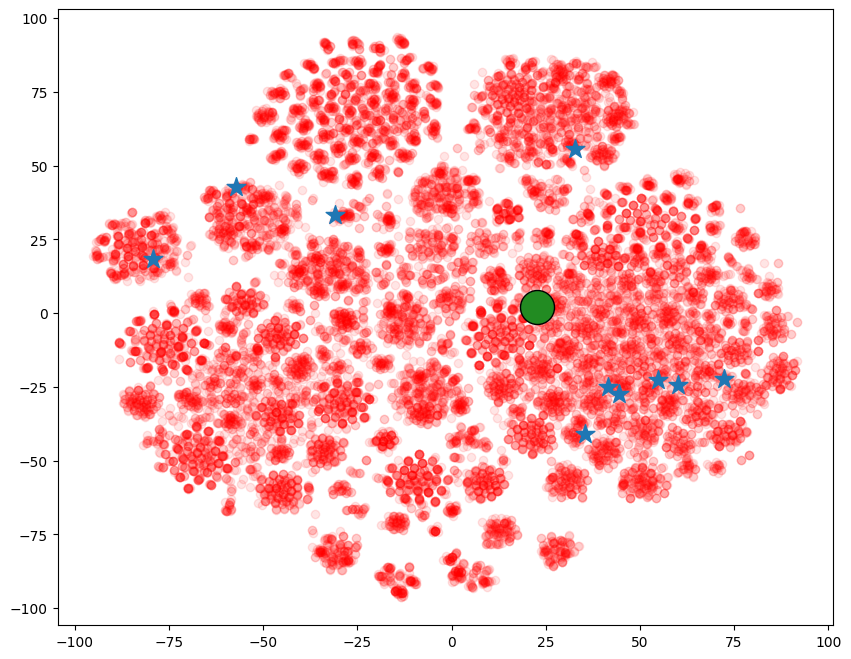

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(red[:, 0], red[:, 1], alpha = 0.1, color = 'red')
closest = avg_w2v_with_category_authors_and_publshing_day_and_sentiment(528,10,0.1,0.1,0.1,1,0.5)
plt.scatter(red[528, 0], red[528, 1], s = 600, edgecolor = 'k', color = 'forestgreen')
p = plt.scatter(red[closest[:], 0], red[closest[:], 1],  cmap = plt.cm.RdBu_r, s = 200, alpha = 1, marker = '*')

============================== Queried article details ==============================
headline :  Rewards Program Encourages SNAP Recipients To Make Healthy Choices
Categoty :  POLITICS
Authors :  Stateline, Editorial Partner
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,cosine,article_sentiment_similarity,Weighted Euclidean similarity with the queried article,BoW based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
1,2018-02-07,Democrats Win Special Election In Missouri Dis...,-0.387279,-1.794204,0.482546,4.242641,1.000000,2.414214,1.0,POLITICS,Amanda Terkel,Wed_Feb
2,2018-02-14,Stormy Daniels Says Trump Lawyer Breached Agre...,-0.392413,-1.812686,0.483871,4.358899,1.000000,2.414214,1.0,POLITICS,Antonia Blumberg,Wed_Feb
3,2018-02-14,Americans Should Get Ready To Spend Even More ...,-0.368902,-1.728047,0.494283,4.123106,1.000000,2.414214,1.0,POLITICS,Jonathan Cohn,Wed_Feb
4,2018-02-28,Hope Hicks Is Leaving The White House,-0.323385,-1.504559,0.502983,3.162278,1.000000,2.414214,1.0,POLITICS,Lydia O'Connor,Wed_Feb
5,2018-02-14,Michelle Obama Made A Valentine's Day Playlist...,-0.339124,-1.620846,0.524060,4.123106,1.000000,2.414214,1.0,POLITICS,Carly Ledbetter,Wed_Feb
6,2018-02-14,Queer Students Celebrate Valentine's Day By Sh...,-0.365329,-1.915184,0.527508,4.242641,2.414214,2.414214,1.0,QUEER VOICES,Curtis M. Wong,Wed_Feb
7,2018-02-14,Sikh Activist's Campaign A Reminder That Love ...,-0.350634,-1.862282,0.528723,4.000000,2.414214,2.414214,1.0,RELIGION,Carol Kuruvilla,Wed_Feb
8,2018-02-14,Shaun White Makes History With Gold Medal Win ...,-0.347812,-1.828553,0.531036,3.872983,2.414214,2.414214,1.0,SPORTS,Josh Butler,Wed_Feb
9,2018-02-14,6 Queer Couples Share Their Definition of Blac...,-0.335887,-1.809192,0.536414,3.872983,2.414214,2.414214,1.0,BLACK VOICES,Princess-India Alexander,Wed_Feb


<ipython-input-80-ee59973cb1da>:5: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



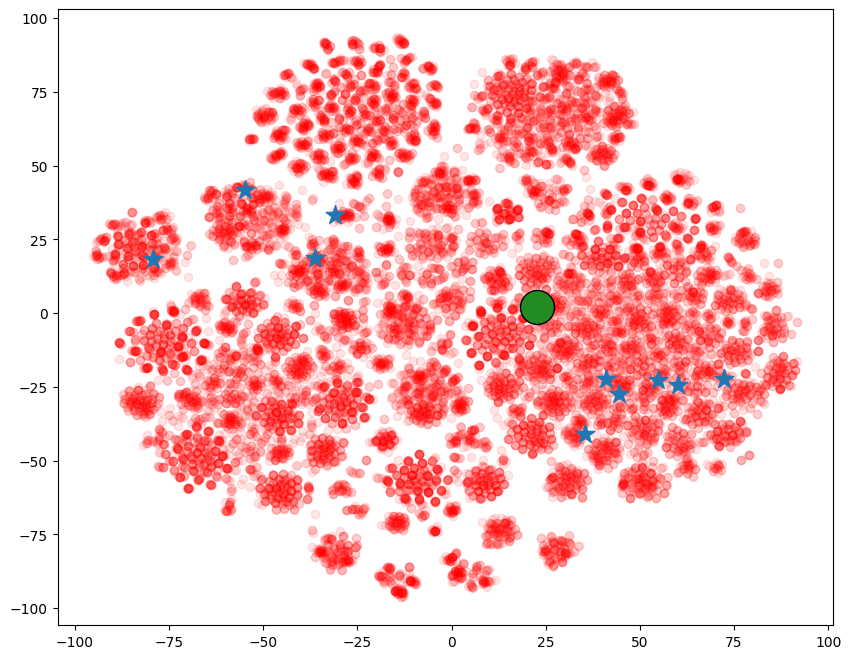

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(red[:, 0], red[:, 1], alpha = 0.1, color = 'red')
closest = avg_bow_with_category_authors_and_publshing_day_and_sentiment(528,10,0.1,0.1,0.1,1,0.5)
plt.scatter(red[528, 0], red[528, 1], s = 600, edgecolor = 'k', color = 'forestgreen')
p = plt.scatter(red[closest[:], 0], red[closest[:], 1],  cmap = plt.cm.RdBu_r, s = 200, alpha = 1, marker = '*')

============================== Queried article details ==============================
headline :  Rewards Program Encourages SNAP Recipients To Make Healthy Choices
Categoty :  POLITICS
Authors :  Stateline, Editorial Partner
Day and month :  Wed_Feb

 ========================= Recommended articles :  =======================


,publish_date,headline_text,article_sentiment_similarity,cosine,Weighted Euclidean similarity with the queried article,tfidf based Euclidean similarity,Category based Euclidean similarity,Authors based Euclidean similarity,Publishing day based Euclidean similarity,Categoty,Authors,Day and month
1,2018-02-14,Stormy Daniels Says Trump Lawyer Breached Agre...,-1.812686,-0.392413,0.320278,1.414214,1.000000,2.414214,1.0,POLITICS,Antonia Blumberg,Wed_Feb
2,2018-02-07,Democrats Win Special Election In Missouri Dis...,-1.794204,-0.387279,0.325412,1.414214,1.000000,2.414214,1.0,POLITICS,Amanda Terkel,Wed_Feb
3,2018-02-14,Americans Should Get Ready To Spend Even More ...,-1.728047,-0.368902,0.343789,1.414214,1.000000,2.414214,1.0,POLITICS,Jonathan Cohn,Wed_Feb
4,2018-02-14,Queer Students Celebrate Valentine's Day By Sh...,-1.915184,-0.365329,0.370373,1.414214,2.414214,2.414214,1.0,QUEER VOICES,Curtis M. Wong,Wed_Feb
5,2018-02-14,Michelle Obama Made A Valentine's Day Playlist...,-1.620846,-0.339124,0.373566,1.414214,1.000000,2.414214,1.0,POLITICS,Carly Ledbetter,Wed_Feb
6,2018-02-14,Freedom Caucus Chairman Warns Paul Ryan To Tre...,-1.585411,-0.329281,0.383410,1.414214,1.000000,2.414214,1.0,POLITICS,Matt Fuller,Wed_Feb
7,2018-02-07,Kevin Durant Slam-Dunking In Super Slow Motion...,-1.862758,-0.350766,0.384936,1.414214,2.414214,2.414214,1.0,SPORTS,Lee Moran,Wed_Feb
8,2018-02-14,Sikh Activist's Campaign A Reminder That Love ...,-1.862282,-0.350634,0.385068,1.414214,2.414214,2.414214,1.0,RELIGION,Carol Kuruvilla,Wed_Feb
9,2020-02-12,"Here Are Pics Of Siba, The Supremely Extra Win...",-1.847880,-0.346633,0.389069,1.414214,2.414214,2.414214,1.0,U.S. NEWS,Josephine Harvey,Wed_Feb


<ipython-input-78-6bc69641ac8a>:5: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



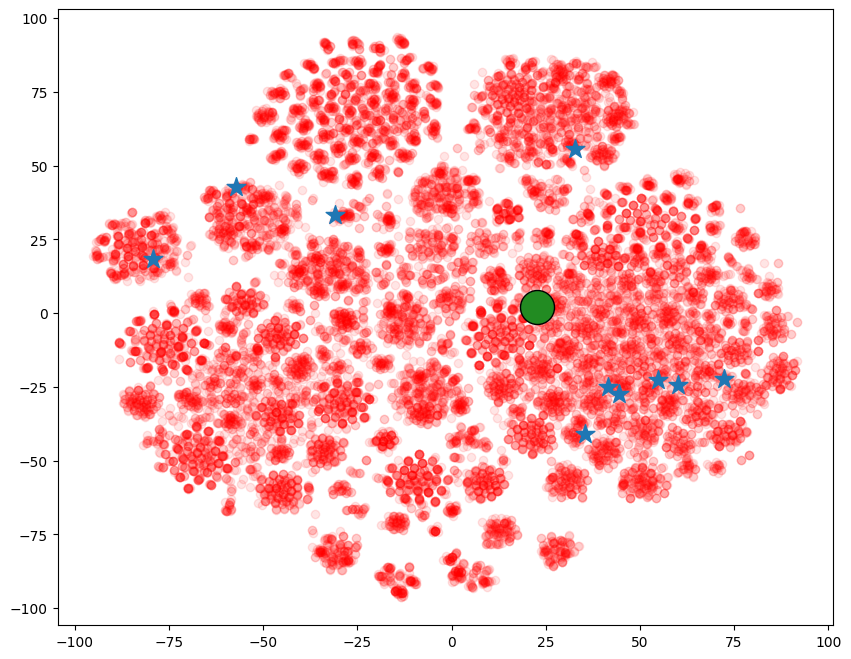

In [ ]:
plt.figure(figsize = (10, 8))
plt.scatter(red[:, 0], red[:, 1], alpha = 0.1, color = 'red')
closest = avg_tfidf_with_category_authors_and_publshing_day_and_sentiment(528,10,0.1,0.1,0.1,1,0.5)
plt.scatter(red[528, 0], red[528, 1], s = 600, edgecolor = 'k', color = 'forestgreen')
p = plt.scatter(red[closest[:], 0], red[closest[:], 1],  cmap = plt.cm.RdBu_r, s = 200, alpha = 1, marker = '*')

In [ ]:
print("hello world")

hello world
